In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle="True",
    image_size= (IMAGE_SIZE,IMAGE_SIZE),
    batch_size= BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 1 1 2 0 0 0 1 1 1 1 0 0 0 2 1 0]


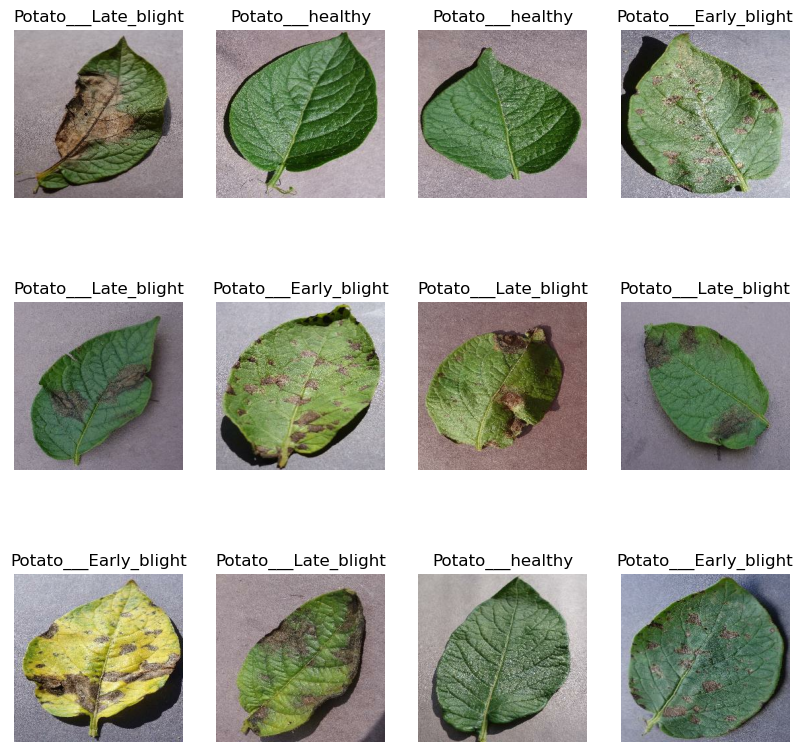

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")
#     print(image_batch[0].shape)

In [8]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [9]:
train_ds = dataset.take(54)
len(train_ds)

54

In [10]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [11]:
val_size = 0.1
len(dataset)*val_size

6.800000000000001

In [12]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [13]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [14]:
def get_dataset_partitions_tf(ds, train_split = 0.8 , val_split = 0.1 , test_split = 0.1 , shuffle = True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

54

In [17]:
len(val_ds)

6

In [18]:
len(test_ds)

8

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [22]:
input_shape =  (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax')
])

model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50


54/54 [==============================] - 75s 1s/step - loss: 0.9051 - accuracy: 0.4844 - val_loss: 0.9124 - val_accuracy: 0.4479
Epoch 2/50
54/54 [==============================] - 67s 1s/step - loss: 0.7900 - accuracy: 0.5966 - val_loss: 0.7138 - val_accuracy: 0.6875
Epoch 3/50
54/54 [==============================] - 68s 1s/step - loss: 0.6347 - accuracy: 0.7176 - val_loss: 0.6433 - val_accuracy: 0.7396
Epoch 4/50
54/54 [==============================] - 61s 1s/step - loss: 0.5028 - accuracy: 0.7928 - val_loss: 0.3989 - val_accuracy: 0.7969
Epoch 5/50
54/54 [==============================] - 59s 1s/step - loss: 0.3540 - accuracy: 0.8519 - val_loss: 0.4529 - val_accuracy: 0.8177
Epoch 6/50
54/54 [==============================] - 69s 1s/step - loss: 0.2116 - accuracy: 0.9196 - val_loss: 0.1731 - val_accuracy: 0.9219
Epoch 7/50
47/54 [=========================>....] - ETA: 9s - loss: 0.1229 - accuracy: 0.9548 

KeyboardInterrupt: 

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
scores

In [ ]:
history

In [ ]:
history.params

In [ ]:
history.history.keys()

In [ ]:
len(history.history['accuracy'])

In [ ]:
history.history['accuracy']

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='Training Loss')
plt.plot(range(EPOCHS),val_loss,label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [31]:
import numpy as np

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("first image's actual label :",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [29]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array,0) #create a batch
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])),2)
    return predicted_class,confidence

In [ ]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis("off")
        

In [ ]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]])+1
model.save(f"../saved_models/{model_version}")

In [26]:
new_model = tf.keras.models.load_model(f"../saved_models/1")
new_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                  

1/1 [==============================] - 0s 32ms/step


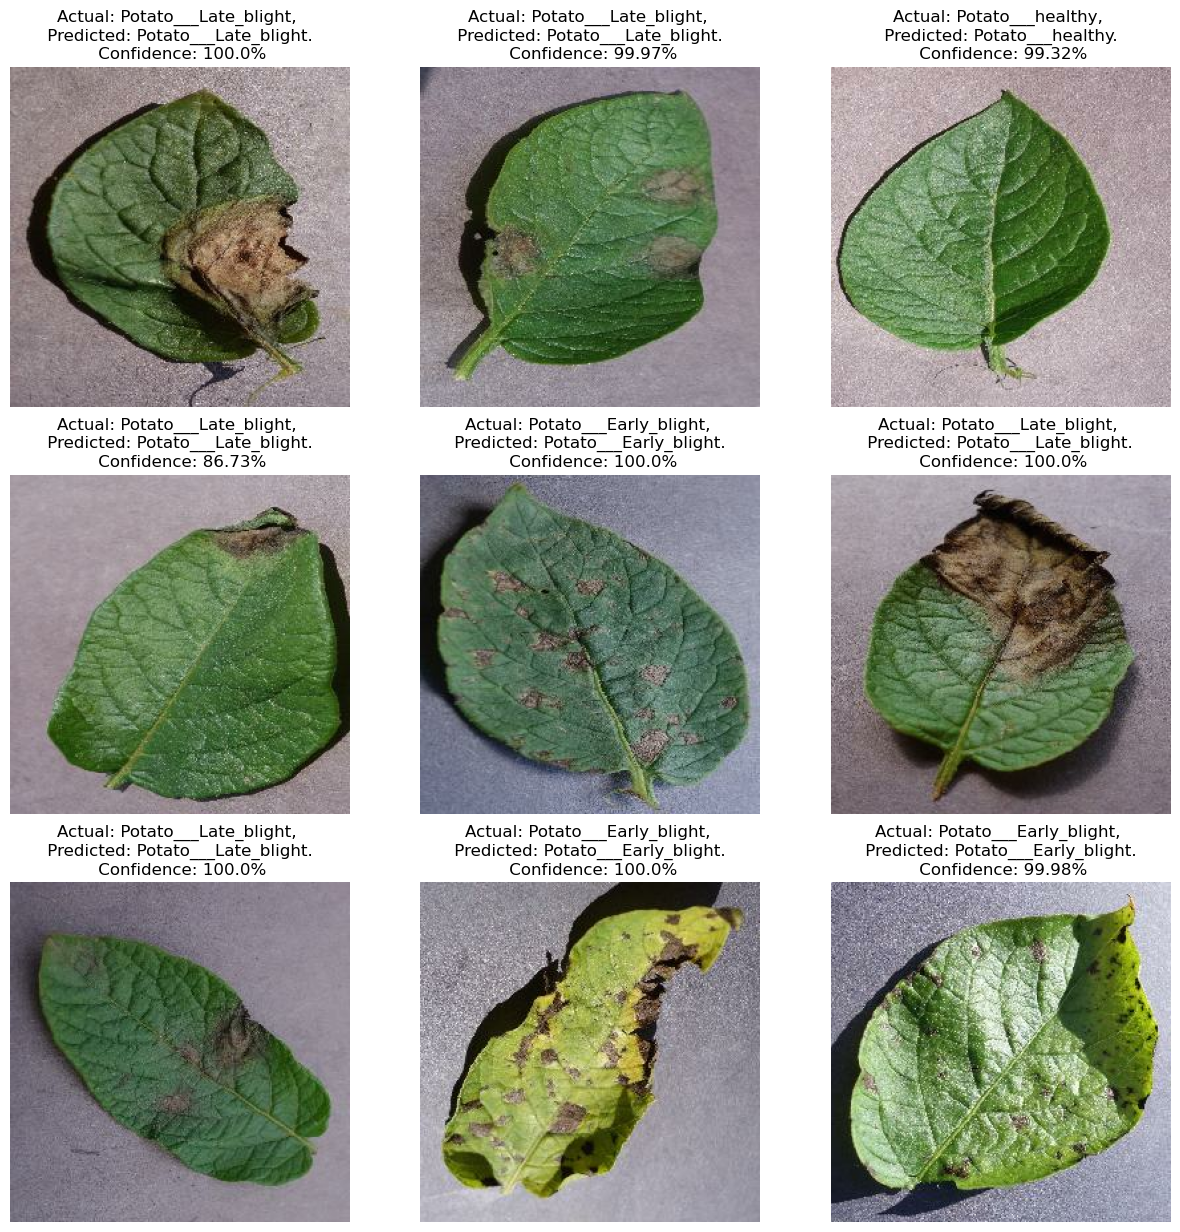

In [41]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(new_model, images[i].numpy())
        actual_class = class_names[labels[i]]
        
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}. \n Confidence: {confidence}%")
        
        plt.axis("off")
        